In [1]:
## GAN TEST 1
import tensorflow as tf
import matplotlib.pyplot as plt
## import sys
import numpy as np
## import tqdm  ## 진행표시

from tensorflow.keras.datasets import mnist ## mnist 데이터셋

In [2]:
## 랜덤시드 설정
np.random.seed(1000)

## mnist Data load
(x_train, _), (_, _) = mnist.load_data()  ## 28 * 28 크기의 이미지 데이터 6만개

# 정규화
## 픽셀값이 0~255 를 가지기 때문에 평균값 127.5를 이용해 정규화 해줌
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = x_train.reshape(60000, 784)

In [3]:
## 생성기
## 생성기 : 훈련 트레인셋과 비슷한 이미지를 생성

randomDim = 10 ## 노이즈 입력 크기
adam = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim = randomDim),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dense(512),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dense(1024),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dense(784, activation='tanh')
])

In [4]:
## 판별기
## 판별기 : 진짜와 가짜를 구분하는 학습 수행

discriminator = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, input_dim=784, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

discriminator.compile(loss='binary_crossentropy', optimizer = adam)

In [5]:
## GAN 구성
## 생성기와 판별기 결합

## 판별기 가중치 고정
discriminator.trainable = False

ganInput = tf.keras.layers.Input(shape=(randomDim,))
x = generator(ganInput)

ganOutput = discriminator(x)

gan = tf.keras.Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer = adam)

In [6]:
gLoss = [] ## 생성기 loss
dLoss = [] ## 판별기 loss

## epoch 당 손실 도식화하는 함수
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(gLoss, label = 'GEN loss')
    plt.plot(dLoss, label = 'DIS loss')
    plt.xlabel('Epoch', color = 'w')
    plt.ylabel('Loss', color = 'w')
    plt.xticks(color = 'w')
    plt.yticks(color = 'w')
    plt.legend()
    plt.savefig('images/gan_loss_epoch_%d.png' % epoch) 

In [7]:
## 생성된 mnist 이미지 나열하는 함수
def saveImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size = [examples, randomDim])
    gen_images = generator.predict(noise)
    gen_images = gen_images.reshape(examples, 28, 28)
    
    plt.figure(figsize=figsize)
    for i in range(gen_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(gen_images[i], interpolation = 'nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/gan_generated_images_epoch_%d.png' % epoch)

In [8]:
## 학습 함수
def train(epochs=1, batchsize = 128):
    batchCount = int(x_train.shape[0] / batchsize)
    print('Epochs : ', epochs)
    print('Batch Size : ', batchsize)
    print('Batches per Epoch : ', batchCount)
    
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            # 인풋 노이즈와 이미지의 랜덤 셋
            noise = np.random.normal(0, 1, size=[batchsize, randomDim])
            imageBatch = x_train[np.random.randint(0, x_train.shape[0], size=batchsize)]
            
            # 가짜 mnist 이미지 생성
            generatedImage = generator.predict(noise)
            X = np.concatenate([imageBatch, generatedImage])
            
            # 생성된 것과 실제 데이터 label
            yDis = np.zeros(2*batchsize)
            # 단면 label 평활화
            yDis[:batchsize] = 0.9
            
            ## 판별기 훈련
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)
            
            ## 생성기 훈련
            noise = np.random.normal(0, 1, size=[batchsize, randomDim])
            yGen = np.ones(batchsize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)
            
        ## 손실 저장
        gLoss.append(gloss)
        dLoss.append(dloss)
        
        if e == 1 or e % 20 == 0: ## 첫번째이거나 20번째 마다 이미지 저장
            saveImages(e)
            
    ## epoch당 loss 그래프
    plotLoss(e)

Epochs :  200
Batch Size :  128
Batches per Epoch :  468
--------------- Epoch 1 ---------------
--------------- Epoch 2 ---------------
--------------- Epoch 3 ---------------
--------------- Epoch 4 ---------------
--------------- Epoch 5 ---------------
--------------- Epoch 6 ---------------
--------------- Epoch 7 ---------------
--------------- Epoch 8 ---------------
--------------- Epoch 9 ---------------
--------------- Epoch 10 ---------------
--------------- Epoch 11 ---------------
--------------- Epoch 12 ---------------
--------------- Epoch 13 ---------------
--------------- Epoch 14 ---------------
--------------- Epoch 15 ---------------
--------------- Epoch 16 ---------------
--------------- Epoch 17 ---------------
--------------- Epoch 18 ---------------
--------------- Epoch 19 ---------------
--------------- Epoch 20 ---------------
--------------- Epoch 21 ---------------
--------------- Epoch 22 ---------------
--------------- Epoch 23 ---------------
---------

--------------- Epoch 198 ---------------
--------------- Epoch 199 ---------------
--------------- Epoch 200 ---------------


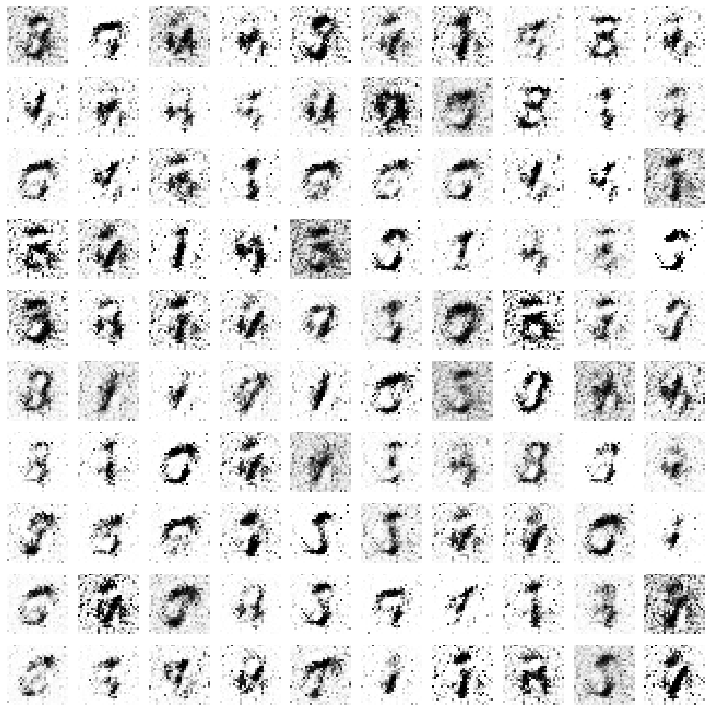

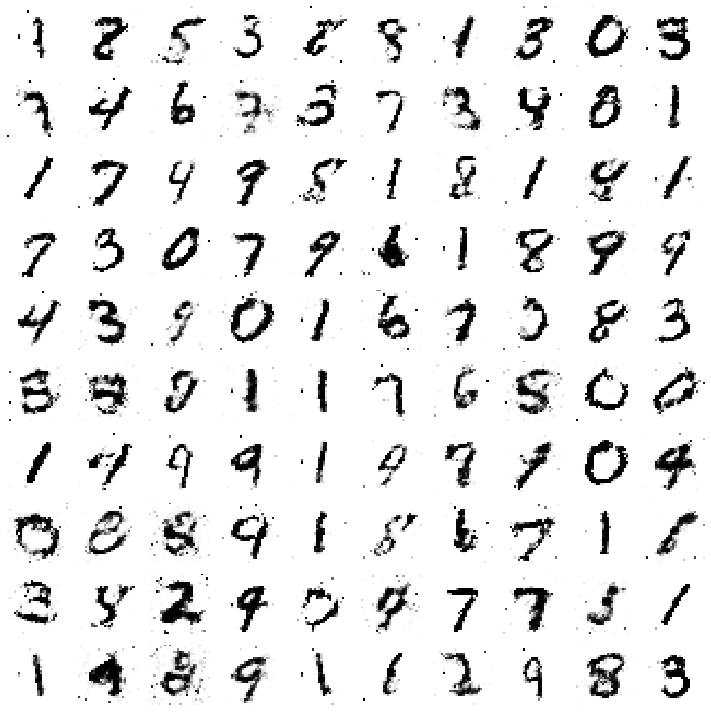

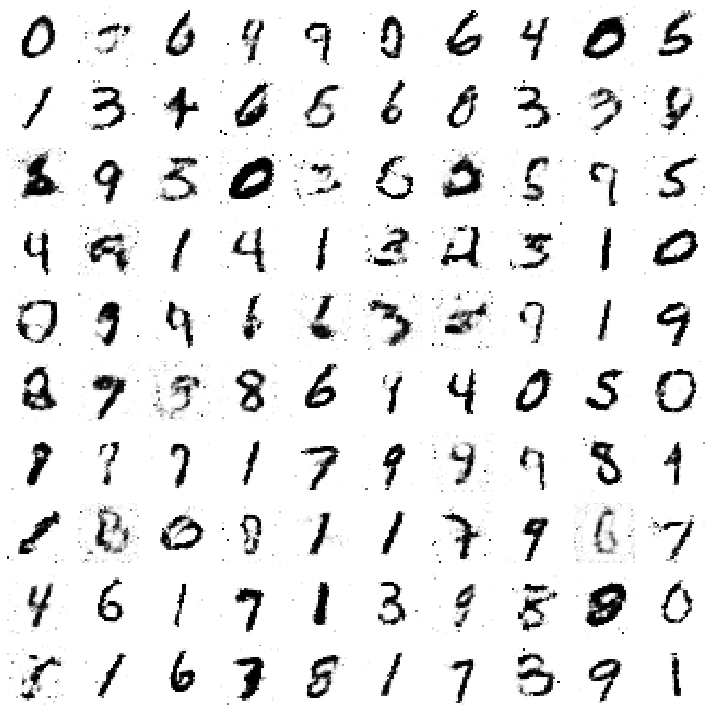

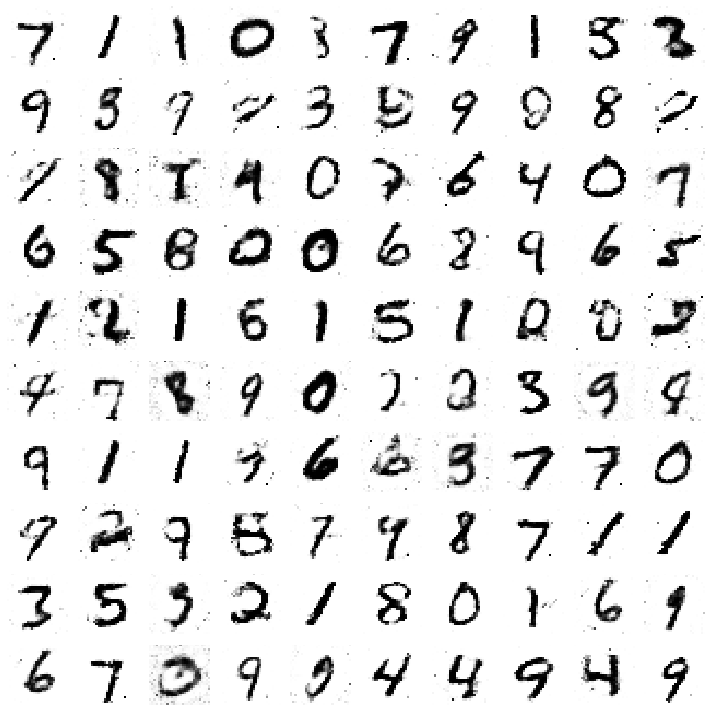

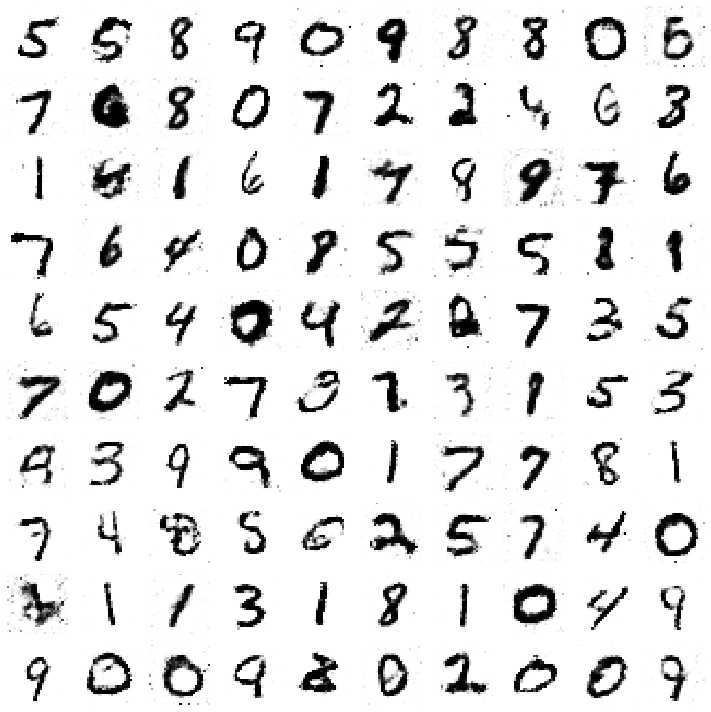

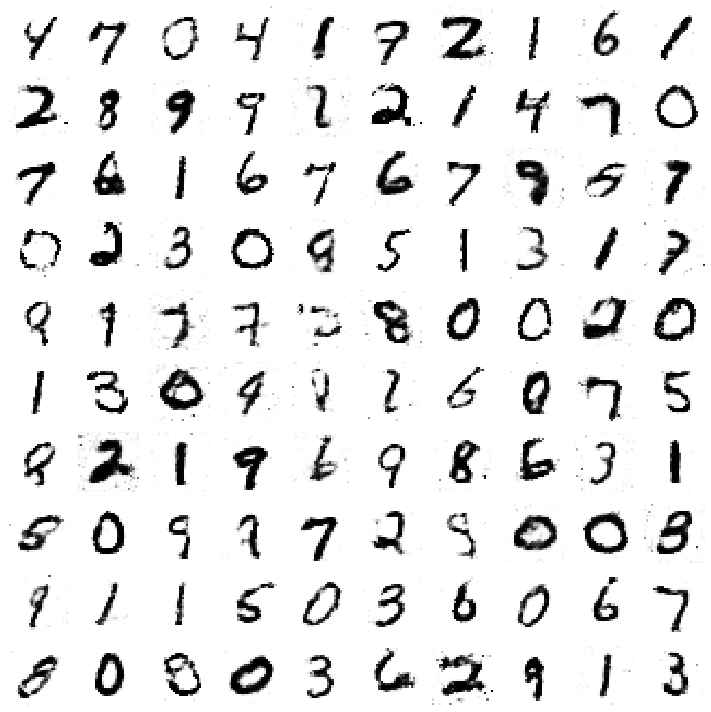

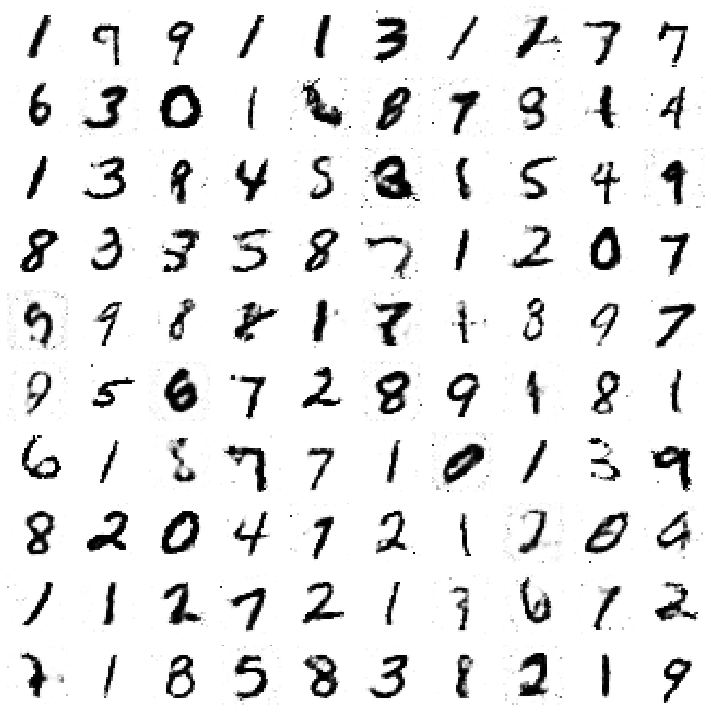

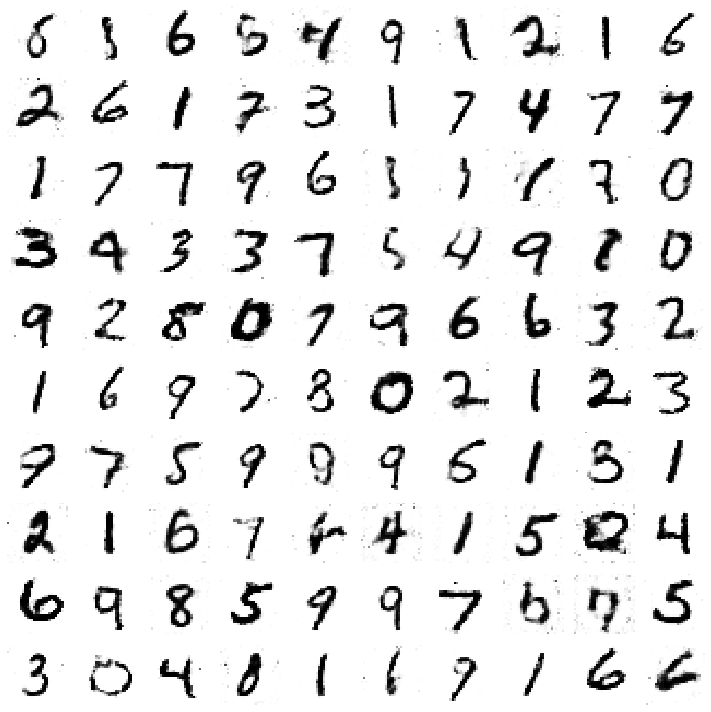

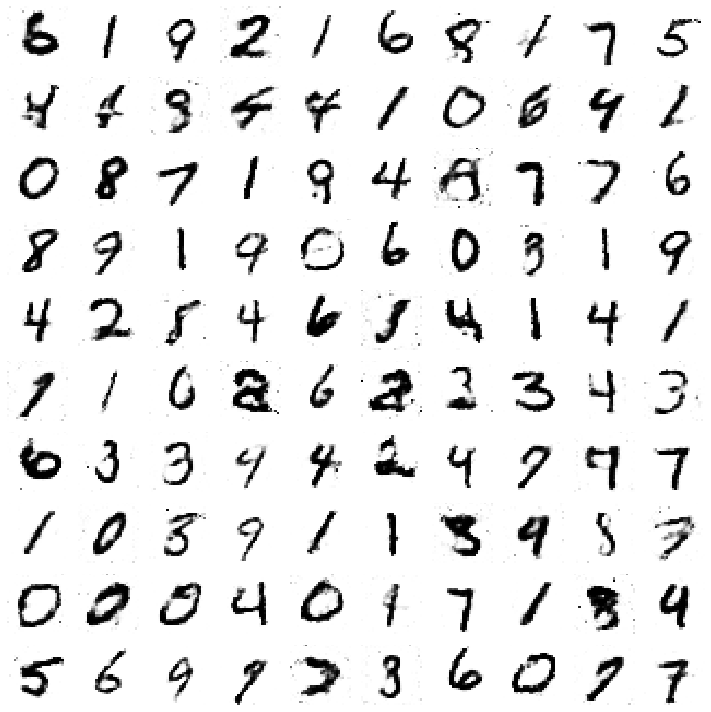

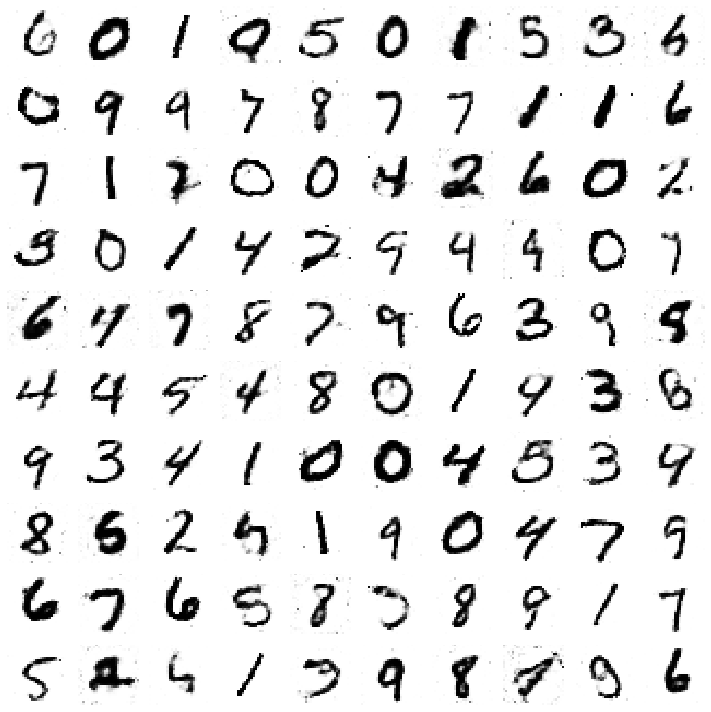

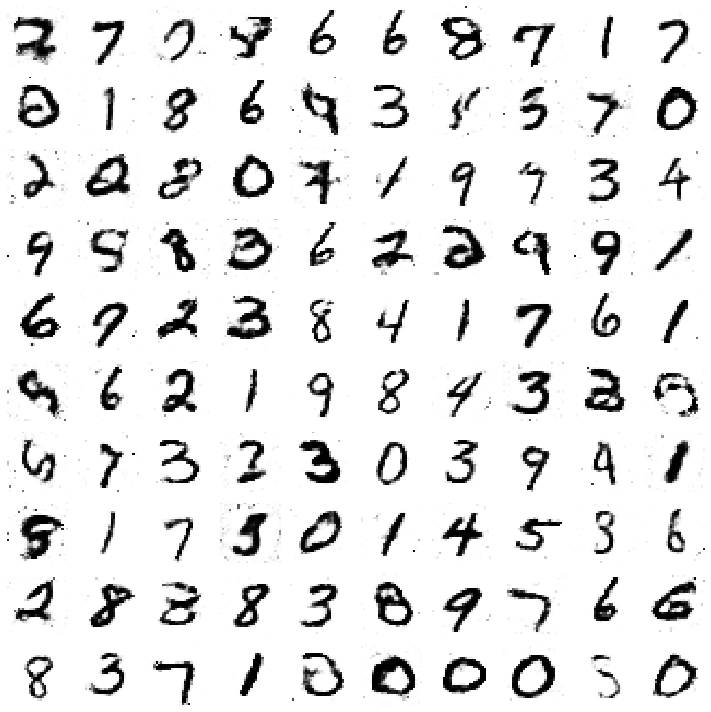

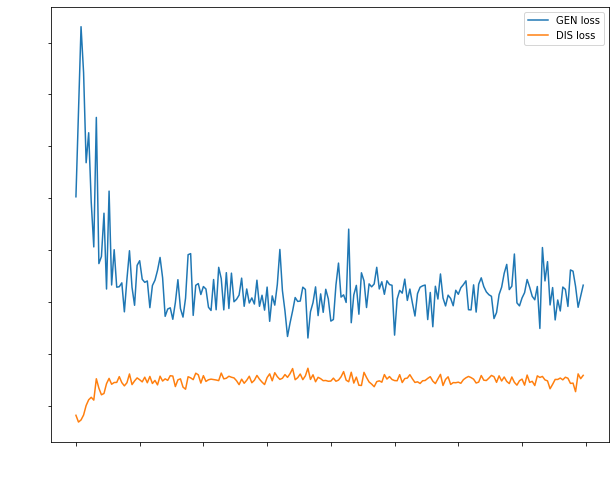

In [9]:
## 실제 훈련
train(200, 128)